In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)

# Simple example

In [2]:
clusters = 3

n_cluster = [90, 50, 75]
n_total = sum(n_cluster)

means = [9, 21, 35]
std_devs = [2, 2, 2]
# example of mixture data
mix = np.random.normal(np.repeat(means, n_cluster), np.repeat(std_devs, n_cluster))

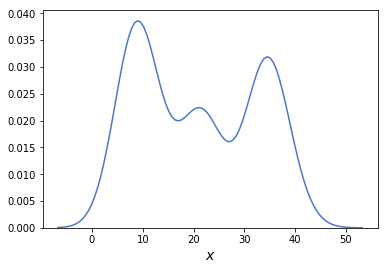

In [3]:
sns.kdeplot(np.array(mix))
plt.xlabel('$x$', fontsize=14);

In [4]:
# Author: Thomas Boggs

import matplotlib.tri as tri
from functools import reduce
from matplotlib import ticker, cm

_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])
_midpoints = [(_corners[(i + 1) % 3] + _corners[(i + 2) % 3]) / 2.0 for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.
    Arguments:
        xy: A length-2 sequence containing the x and y value.
    '''
    s = [(_corners[i] - _midpoints[i]).dot(xy - _midpoints[i]) / 0.75 for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        '''Creates Dirichlet distribution with parameter `alpha`.'''
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) /reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])
    def sample(self, N):
        '''Generates a random sample of size `N`.'''
        return np.random.dirichlet(self._alpha, N)

def draw_pdf_contours(dist, nlevels=100, subdiv=8, **kwargs):
    '''Draws pdf contours over an equilateral triangle (2-simplex).
    Arguments:
        dist: A distribution instance with a `pdf` method.
        border (bool): If True, the simplex border is drawn.
        nlevels (int): Number of contours to draw.
        subdiv (int): Number of recursive mesh subdivisions to create.
        kwargs: Keyword args passed on to `plt.triplot`.
    '''
    refiner = tri.UniformTriRefiner(_triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap=cm.Blues, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

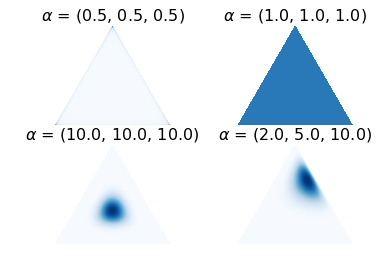

In [5]:
alphas = [[0.5] * 3, [1] * 3, [10] * 3, [2, 5, 10]]
for (i, alpha) in enumerate(alphas):
    plt.subplot(2, 2, i + 1)
    dist = Dirichlet(alpha)
    draw_pdf_contours(dist)
    
    plt.title(r'$\alpha$ = ({:.1f}, {:.1f}, {:.1f})'.format(*alpha), fontsize=16)

In [6]:
with pm.Model() as model_kg:
    # Each observation is assigned to a cluster/component with probability p
    p = pm.Dirichlet('p', a=np.ones(clusters))
    category = pm.Categorical('category', p=p, shape=n_total) 
    
    # Known Gaussians means
    means = pm.math.constant([10, 20, 35])

    y = pm.Normal('y', mu=means[category], sd=2, observed=mix)

    step1 = pm.ElemwiseCategorical(vars=[category], values=range(clusters))
    ## The CategoricalGibbsMetropolis is a recent addition to PyMC3
    ## I have not find the time yet to experiment with it.
    #step1 = pm.CategoricalGibbsMet\ropolis(vars=[category]) 
    step2 = pm.Metropolis(vars=[p])
    trace_kg = pm.sample(10000, step=[step1, step2],chains=1,njobs=1)

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  # This is added back by InteractiveShellApp.init_path()
Sequential sampling (1 chains in 1 job)
CompoundStep
>ElemwiseCategorical: [category]
>Metropolis: [p]
100%|██████████| 10500/10500 [00:30<00:00, 349.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


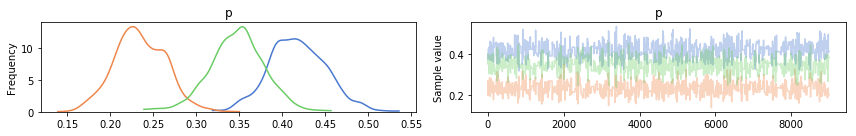

In [7]:
chain_kg = trace_kg[1000:]
varnames_kg = ['p']
pm.traceplot(chain_kg, varnames_kg);

In [8]:
print(pm.summary(chain_kg, varnames_kg))
n_cluster_array = np.array(n_cluster)
print('\n')
print('Actual values of cluster fractions: {}'.format(n_cluster_array/n_cluster_array.sum()))

          mean        sd  mc_error   hpd_2.5  hpd_97.5
p__0  0.418133  0.032734  0.001302  0.347043  0.475764
p__1  0.234513  0.029194  0.001281  0.173813  0.285907
p__2  0.347354  0.032026  0.001378  0.281533  0.406833


Actual values of cluster fractions: [0.42 0.23 0.35]


In [9]:
with pm.Model() as model_ug:
    # Each observation is assigned to a cluster/component with probability p
    p = pm.Dirichlet('p', a=np.ones(clusters))
    category = pm.Categorical('category', p=p, shape=n_total) 
    
    # We estimate the unknown gaussians means and standard deviation
    means = pm.Normal('means', mu=[10, 20, 35], sd=2, shape=clusters)
    sd = pm.HalfCauchy('sd', 5)

    y = pm.Normal('y', mu=means[category], sd=sd, observed=mix)

    step1 = pm.ElemwiseCategorical(vars=[category], values=range(clusters))
    step2 = pm.Metropolis(vars=[means, sd, p])
    trace_ug = pm.sample(10000, step=[step1, step2],chains=1,njobs=1)

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  if sys.path[0] == '':
Sequential sampling (1 chains in 1 job)
CompoundStep
>ElemwiseCategorical: [category]
>CompoundStep
>>Metropolis: [p]
>>Metropolis: [sd]
>>Metropolis: [means]
100%|██████████| 10500/10500 [00:35<00:00, 297.53it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


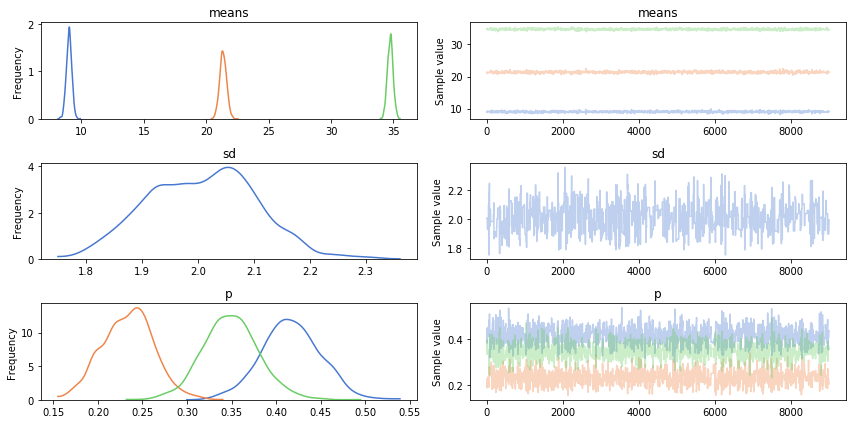

In [10]:
chain_ug = trace_ug[1000:]
varnames_ug = ['means', 'sd', 'p']
pm.traceplot(chain_ug, varnames_ug);

In [11]:
print(pm.summary(chain_ug, varnames_ug))
means_array = np.array([9, 21, 35])
std_devs = [2, 2, 2]
print('\n')
print('Actual values of cluster fractions: {}'.format(n_cluster_array/n_cluster_array.sum()))
print('Actual values of cluster means: {}'.format(means_array))
print('Actual values of cluster sd: {}'.format(std_devs))

               mean        sd  mc_error    hpd_2.5   hpd_97.5
means__0   9.008717  0.217561  0.007712   8.613627   9.463408
means__1  21.356761  0.275587  0.010145  20.812555  21.887742
means__2  34.742823  0.225639  0.008249  34.304095  35.202331
sd         2.008365  0.097757  0.004210   1.821559   2.183144
p__0       0.417117  0.033083  0.001022   0.351142   0.480680
p__1       0.233721  0.028664  0.000926   0.172529   0.283838
p__2       0.349161  0.030978  0.001001   0.288788   0.411532


Actual values of cluster fractions: [0.42 0.23 0.35]
Actual values of cluster means: [ 9 21 35]
Actual values of cluster sd: [2, 2, 2]


In [12]:
ppc = pm.sample_ppc(chain_ug, 50, model_ug)

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 50/50 [00:00<00:00, 998.86it/s]


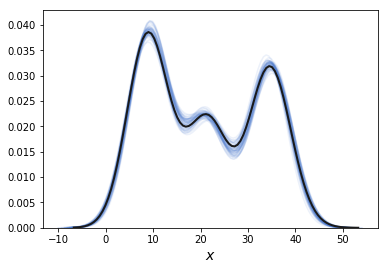

In [13]:
for i in ppc['y']:
    sns.kdeplot(i, alpha=0.1, color='b')
sns.kdeplot(np.array(mix), lw=2, color='k');
plt.xlabel('$x$', fontsize=14);

#### Note the higher uncertainty where the data overlap and the reduced uncertainty at the high/low limits

## Marginalized Gaussian Mixture model

### In the previous models we have explicitly defined the latent variable $z$ in the model. This is ineffective in terms of sampling. PyMC3 offers the ability to model the outcome conditionaly on $z$ as $p(y|z,\theta)$ and marginalise it to get $p(y|\theta)$

In [14]:
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))

    means = pm.Normal('means', mu=[10, 20, 35], sd=2, shape=clusters)
    sd = pm.HalfCauchy('sd', 5)
    
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=mix)
    
    trace_mg = pm.sample(5000, chains=1,njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd, means, p]
100%|██████████| 5500/5500 [00:08<00:00, 637.72it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


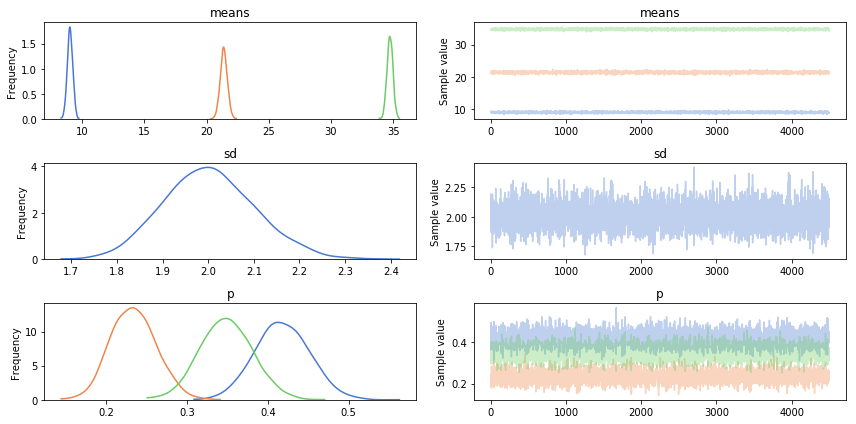

In [15]:
chain_mg = trace_mg[500:]
varnames_mg = ['means', 'sd', 'p']
pm.traceplot(chain_mg, varnames_mg);

## Zero inflated Poisson model

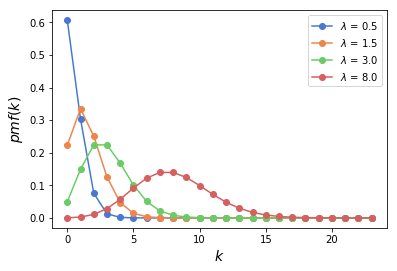

In [16]:
lam_params = [0.5, 1.5, 3, 8]
k = np.arange(0, max(lam_params) * 3)
for lam in lam_params:
    y = stats.poisson(lam).pmf(k)
    plt.plot(k, y, 'o-', label="$\\lambda$ = {:3.1f}".format(lam))
plt.legend();
plt.xlabel('$k$', fontsize=14);
plt.ylabel('$pmf(k)$', fontsize=14);

In [17]:
np.random.seed(42)
n = 100
lam_true = 2.5  # Poisson rate
pi = 0.2  # probability of extra-zeros (pi = 1-psi)

# Simulate some data
counts = np.array([(np.random.random() > pi) * np.random.poisson(lam_true) for i in range(n)])

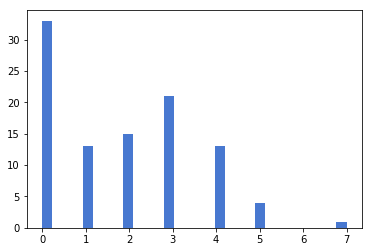

In [18]:
plt.hist(counts, bins=30);

In [19]:
with pm.Model() as ZIP:
    psi = pm.Beta('psi', 1, 1)
    lam = pm.Gamma('lam', 2, 0.1)
    
    y_pred = pm.ZeroInflatedPoisson('y_pred', theta=lam, psi=psi, observed=counts)
    trace_ZIP = pm.sample(5000,chains=1,njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [lam, psi]
100%|██████████| 5500/5500 [00:03<00:00, 1652.34it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


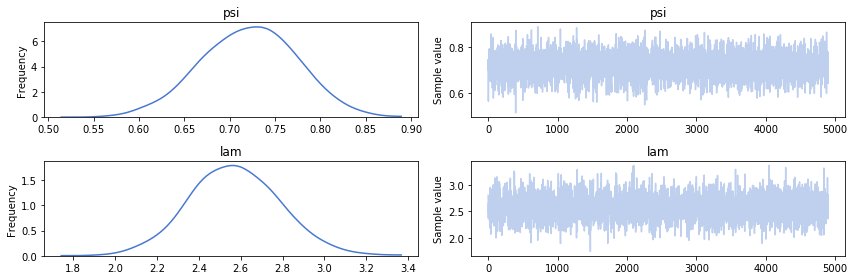

In [20]:
chain_ZIP = trace_ZIP[100:]
pm.traceplot(chain_ZIP);

In [21]:
pm.summary(chain_ZIP)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
psi,0.721471,0.052295,0.000769,0.619399,0.823200
lam,2.572429,0.214952,0.003234,2.154592,3.001078


## Zero inflated Poisson regression

In [22]:
#Kruschke plot

In [23]:
fish_data = pd.read_csv('fish.csv')
fish_data.head()

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


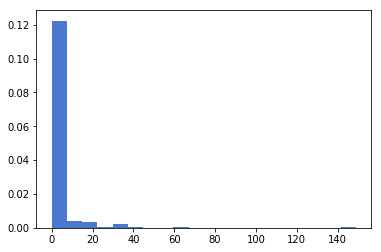

In [24]:
plt.hist(fish_data['count'], bins=20, normed=True);

In [25]:
with pm.Model() as ZIP_reg:
    psi = pm.Beta('psi', 1, 1)
    
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 10, shape=2)
    lam = pm.math.exp(alpha + beta[0] * fish_data['child'] + beta[1] * fish_data['camper'])
    
    y = pm.ZeroInflatedPoisson('y', theta=lam, psi=psi, observed=fish_data['count'])
    trace_ZIP_reg = pm.sample(2000,chains=1,njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta, alpha, psi]
100%|██████████| 2500/2500 [00:05<00:00, 437.66it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


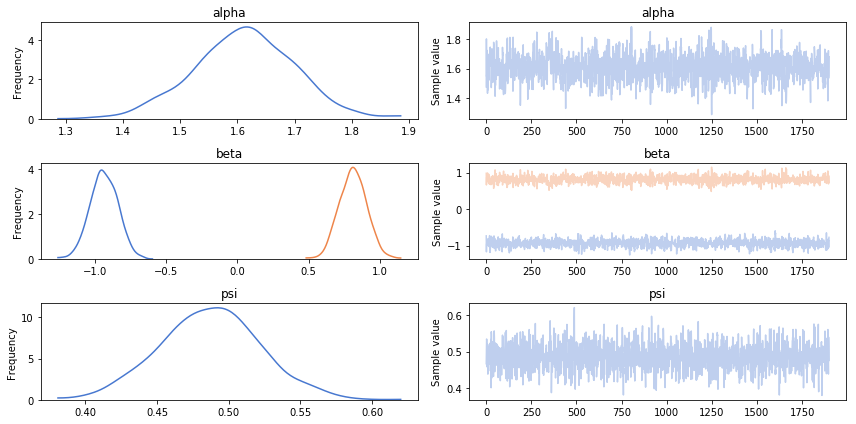

In [26]:
chain_ZIP_reg = trace_ZIP_reg[100:]
pm.traceplot(chain_ZIP_reg);

In [27]:
pm.summary(chain_ZIP_reg)


,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,1.610313,0.088094,0.002596,1.427976,1.771882
beta__0,-0.936188,0.097573,0.002547,-1.131112,-0.753889
beta__1,0.810109,0.096980,0.002897,0.621544,0.992202
psi,0.486522,0.034692,0.000816,0.419652,0.556741


In [28]:
children =  [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []
thin = 5
# calculate the expectation lambda with and withour a camper for difference number of children
# note lambda from the model is exp(a+bX)
for n in children:
    without_camper = chain_ZIP_reg['alpha'][::thin] + chain_ZIP_reg['beta'][:,0][::thin] * n
    with_camper = without_camper + chain_ZIP_reg['beta'][:,1][::thin]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))

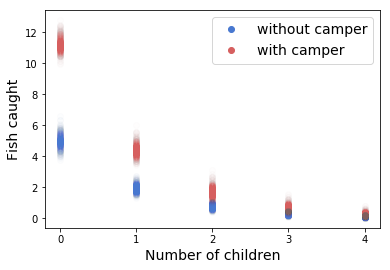

In [29]:
plt.plot(children, fish_count_pred_0, 'bo', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'ro', alpha=0.01)

plt.xticks(children);
plt.xlabel('Number of children', fontsize=14)
plt.ylabel('Fish caught', fontsize=14)
plt.plot([], 'bo', label='without camper')
plt.plot([], 'ro', label='with camper')
plt.legend(fontsize=14);

## Robust logistic Regression

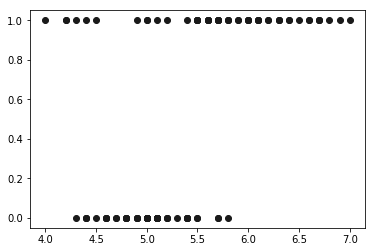

In [30]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values
# contaminate our set with ones with unusually small sepal length
y_0 = np.concatenate((y_0, np.ones(6)))
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4]))
x_0_m = x_0 - x_0.mean()
plt.plot(x_0, y_0, 'o', color='k');

In [31]:
with pm.Model() as model_rlg:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha_tmp + beta * x_0_m
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    # add the mixture here as a combination of the logistic derived theta 
    # and a random pi from a Beta distribution
    pi = pm.Beta('pi', 1, 1)
    p = pi * 0.5 + (1 - pi) * theta
    # correct alpha from centering
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_0.mean())
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl', p=p, observed=y_0)

    trace_rlg = pm.sample(2000, njobs=1,chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [pi, beta, alpha_tmp]
100%|██████████| 2500/2500 [00:02<00:00, 1131.39it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


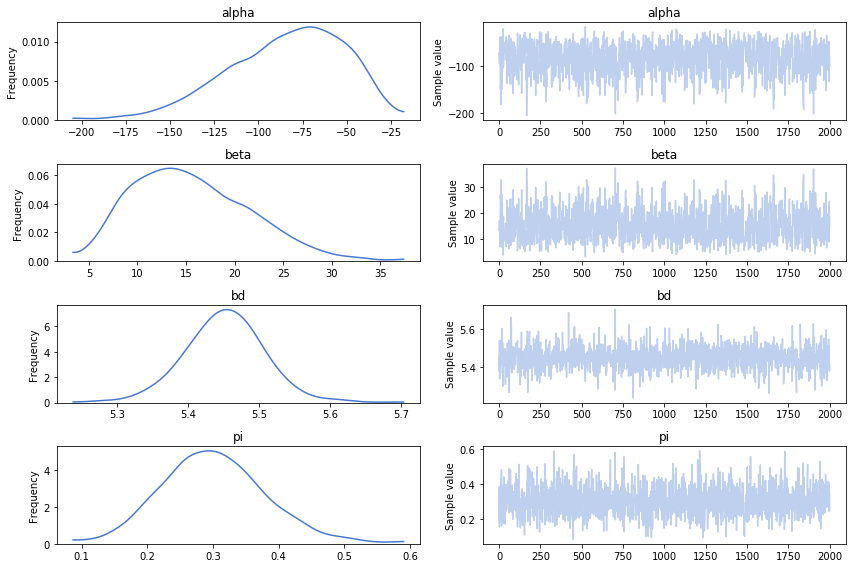

In [32]:
varnames = ['alpha', 'beta', 'bd', 'pi']
pm.traceplot(trace_rlg, varnames);

In [33]:
pm.summary(trace_rlg, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-84.752824,32.430609,1.204960,-145.679729,-28.152112
beta,15.543885,5.935414,0.219442,5.178316,26.580590
bd,5.450754,0.055642,0.001486,5.337383,5.553501
pi,0.300910,0.079280,0.002478,0.145793,0.453829


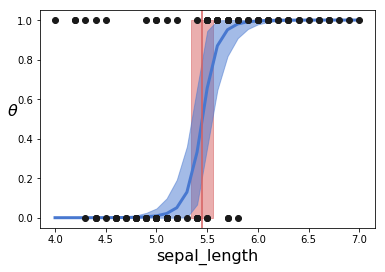

In [34]:
theta = trace_rlg['theta'].mean(axis=0)
idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='b', lw=3);
plt.axvline(trace_rlg['bd'].mean(), ymax=1, color='r')
bd_hpd = pm.hpd(trace_rlg['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k');
theta_hpd = pm.hpd(trace_rlg['theta'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5);

plt.xlabel(x_n, fontsize=16);
plt.ylabel('$\\theta$', rotation=0, fontsize=16);

In [35]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\nPandas %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__, pd.__version__))

This notebook was created on a x86_64 computer running debian buster/sid and using:
Python 3.7.2
IPython 7.2.0
PyMC3 3.6
NumPy 1.16.0
SciPy 1.2.0
Matplotlib 3.0.2
Seaborn 0.9.0
Pandas 0.23.4


/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  
